In [1]:
from bin.cryptoClass import Crypto
import pandas as pd
import numpy as np
import re
import datetime 
import time
import copy
import math
from decimal import *
import matplotlib.pyplot as plt
from matplotlib import interactive
import matplotlib.patches as mpatches
from gplearn.genetic import SymbolicRegressor
from sklearn import tree
from sklearn import ensemble
import matplotlib.dates
import pytz
def lsArr2(lis,regList):
    #regList must be trained
    X=lis[2]
    y=lis[0]
    time=lis[1]
    day=datetime.timedelta(seconds=3600*24)
    date1=time[0]
    date2=time[len(time)-1]
    temp=list([time[0]])
    date1=date1+day
    while(date2>date1):  
        temp=temp+list([date1])
        date1=date1+day
    time=np.array(temp)
    y_true=main2.dateFunc(time)


    temp=np.vectorize(lambda x:x.total_seconds())(time-main2.startDate)

    Temp2=np.ndarray([temp.shape[0],X.shape[1]])#Fill this array
    Temp2[:,0]=temp
    Temp2[0,1:]=X[0,1:]
    y_predict=np.empty([Temp2.shape[0],len(regList)])

    for k in range(len(regList)):
        y_predict[0,k]=regList[k].predict(X[0,:].reshape(1,-1))
    for j in range(len(regList)):

        for i in range(1,Temp2.shape[0]):
            Temp2[i,1]=y_predict[i-1,j]
            Temp2[i,2:]=X[i-1,1:X.shape[1]-1]
            y_predict[i,j]=regList[j].predict(X[i,:].reshape(1,-1))
    X=Temp2
    return(y_predict,time,y_true,X)

def lsArr3(lis):
    X=lis[2]
    for i in range(1,X.shape[0]):
        X[i,1:]=X[0,1:]
    return(lis[0],lis[1],X)

# Main

In [2]:
main=Crypto('./data/temp2.txt')
main.head()

Head: 
        BTC   LTC    ETH         Y:M:D:h:m:s     Ti-T0
0   979.56  4.42   8.33 2017-01-01 01:01:01       0.0
1  1013.13  4.56   8.24 2017-01-02 01:01:01   86400.0
2  1019.53  4.54   8.89 2017-01-03 01:01:01  172800.0
3  1083.63  4.65  10.56 2017-01-04 01:01:01  259200.0
4  1055.36  4.45  10.65 2017-01-05 01:01:01  345600.0 
Tail: 
          BTC    LTC     ETH         Y:M:D:h:m:s       Ti-T0
541  6201.48  80.27  448.58 2018-06-26 01:01:01  46742400.0
542  6094.63  78.24  433.01 2018-06-27 01:01:01  46828800.0
543  6082.69  78.87  434.25 2018-06-28 01:01:01  46915200.0
544  5904.67  74.38  415.87 2018-06-29 01:01:01  47001600.0
545  6362.72  81.27  449.09 2018-06-30 01:01:01  47088000.0


Three different regressors will be tested in these notebooks. In this first section, these regressors are fitted with the prices of bitcoin in the past. The function main.lsArr() has parameters to adjust the number of past bitcoin prices each sample will take as well as how far back we want to sample from. In the cell below, we select 10 different prices in the span of 1 week before the time of each sample. Each regressor is then plotted against the dates that they were trained with.

/home/hunterlum/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    26.82      1.51918e+55        5          14.9221          16.4003      0.00s


/home/hunterlum/.local/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


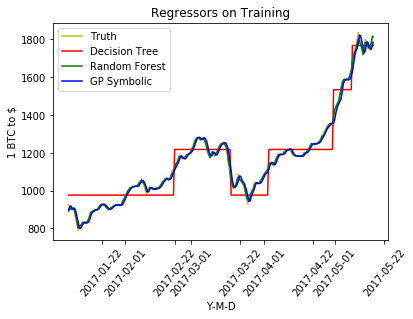

In [3]:
est_tree = tree.DecisionTreeRegressor(max_depth=2)
est_rf = ensemble.RandomForestRegressor()
est_gp = SymbolicRegressor(population_size=5000,tournament_size=1000,
                           generations=1, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0,metric='mean absolute error')

regList=list([est_tree,est_rf,est_gp])
date=main.datePart(4)[2]
lbl=(['Truth','Decision Tree', 'Random Forest','GP Symbolic'])

#Training
ls=main.lsArr(startDate=date[0],endDate=date[1],freq=3600*12,n=10,curr='BTC',past=datetime.timedelta(7))
regList=main.train(regList=regList,lis=ls)
yArray=main.predict(regList,lis=ls)
yArray=np.concatenate([ls[0].reshape(-1,1),yArray],axis=1)

plt.title("Regressors on Training")
plt.xlabel("Y-M-D")
plt.ylabel("1 BTC to $")
main.plot(yArray,ls,col=('y-','r-','g-','b-'),label=lbl)

The regressors are now used to predict the prices of bitcoin in the future with a plot shown below.

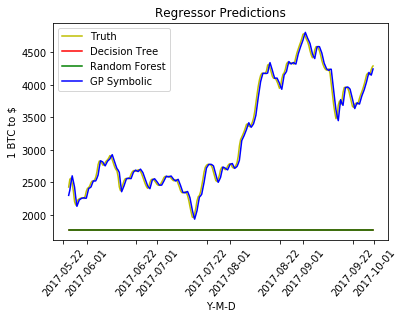

In [4]:
#Predicting
ls2=main.lsArr(startDate=date[1],endDate=date[2],freq=3600*12,n=10,curr='BTC')
yArray=main.predict(regList,lis=ls2)
yArray=np.concatenate([ls2[0].reshape(-1,1),yArray],axis=1)

plt.title("Regressor Predictions")
plt.xlabel("Y-M-D")
plt.ylabel("1 BTC to $")
main.plot(yArray,ls2,col=('y-','r-','g-','b-'),label=lbl)

Though the symbolic regressor seems to predict the future well, it is to note that this regressor is being trained on data that we already have. This means that we would not be able to train, let alone reproduce the above results unless we already know the bitcoin prices in the above date range.

Random forest and the decision tree were unable to accurately predict future prices. It may be interesting to see how these results vary if parameters were adjusted.

# Main2

In main2, the regressor are trained in the same way as main. The resulting regressors are then used to iteratively project the price of bitcoin. This is achieved by using the lsArr2 function. Results are shown below.

/home/hunterlum/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    26.82      1.51918e+55        5          14.9221          16.4003      0.00s


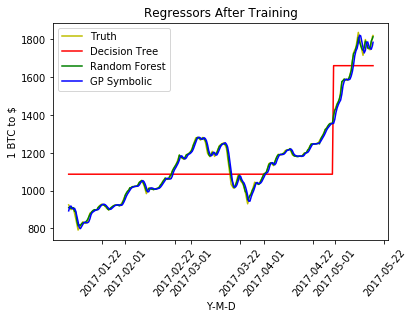

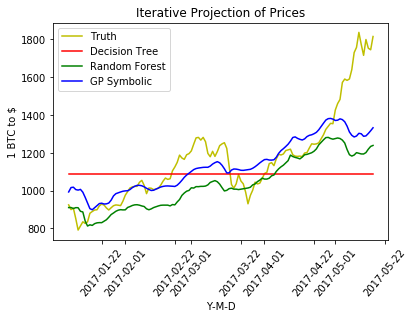

In [5]:
main2=Crypto('./data/temp2.txt')

est_tree = tree.DecisionTreeRegressor(max_depth=1)
est_rf = ensemble.RandomForestRegressor()
est_gp = SymbolicRegressor(population_size=5000,tournament_size=1000,
                           generations=1, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0,metric='mean absolute error')

regList=list([est_tree,est_rf,est_gp])
date=main2.datePart(4)[2]

#Training
ls=main2.lsArr(startDate=date[0],endDate=date[1],freq=3600*12,n=10,curr='BTC')
regList=main2.train(regList=regList,lis=ls)
yArray=main2.predict(regList,lis=ls)
yArray=np.concatenate([ls[0].reshape(-1,1),yArray],axis=1)

plt.title("Regressors After Training")
plt.xlabel("Y-M-D")
plt.ylabel("1 BTC to $")
main2.plot(yArray,ls,col=('y-','r-','g-','b-'),label=lbl)

#Using regressors to iteratively predict prices
ls2=lsArr2(lis=ls,regList=regList)
ls2[0][:,2]=ls2[0][:,2]+100
yArr=np.concatenate([ls2[2].reshape(-1,1),ls2[0]],axis=1)

plt.title("Iterative Projection of Prices")
plt.xlabel("Y-M-D")
plt.ylabel("1 BTC to $")
main2.plot(yArr=yArr,lis=ls2,col=('y-','r-','g-','b-'),label=lbl)


As expected, the regressors aren't very successful in predicting prices.

# Main3

In main3, each sample that is trained on are given the same price points. These are all price points of bitcoin before the time of every sample. To accomplish this, lsArr3 is used. This function takes the price points used to train the first sample and copy its values to every subsequent training sample.

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/home/hunterlum/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


   0    27.30      4.63697e+48        9           168.53          294.961      0.00s


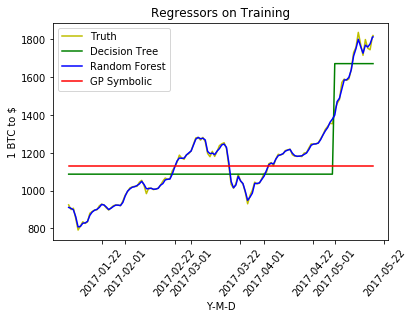

In [6]:
main3=Crypto('./data/temp2.txt')

est_tree = tree.DecisionTreeRegressor(max_depth=1)
est_rf = ensemble.RandomForestRegressor()
est_gp = SymbolicRegressor(population_size=5000,tournament_size=1000,
                           generations=1, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,n_jobs=2,
                           parsimony_coefficient=1e-9, random_state=None,metric='mean absolute error')

regList=list([est_tree,est_rf,est_gp])
date=main3.datePart(4)[2]

#Training
ls=main3.lsArr(startDate=date[0],endDate=date[1],freq=3600*24,n=10,curr='BTC')
ls=lsArr3(lis=ls)
regList=main3.train(regList=regList,lis=ls)
yArray=main3.predict(regList=regList,lis=ls)
yArray=np.concatenate([ls[0].reshape(-1,1),yArray],axis=1)

plt.title("Regressors on Training")
plt.xlabel("Y-M-D")
plt.ylabel("1 BTC to $")
main3.plot(yArray,ls,col=('y-','g-','b-','r-'),label=lbl)

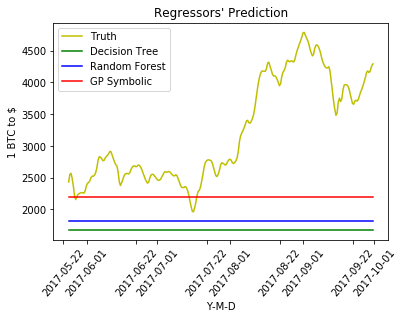

In [7]:
#Predicting
ls2=main3.lsArr(startDate=date[1],endDate=date[2],freq=3600*12,n=10,curr='BTC')
ls2=lsArr3(lis=ls2)
yArray=main.predict(regList,lis=ls2)
yArray=np.concatenate([ls2[0].reshape(-1,1),yArray],axis=1)

plt.title("Regressors' Prediction")
plt.xlabel("Y-M-D")
plt.ylabel("1 BTC to $")
main3.plot(yArray,ls2,col=('y-','g-','b-','r-'),label=lbl)